In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datasets import Dataset, DatasetDict
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Data from All Models

In [2]:
# Define base directory and model names
base_dir = Path("../outputs/caption_inference")
models = ['zero_shot', 'base_random', 'base_vae', 'ft_random', 'ft_vae']
splits = ['train', 'validation', 'test']

# Load all predictions and metrics
predictions = {}
metrics = {}

for model in models:
    predictions[model] = {}
    metrics[model] = {}
    
    for split in splits:
        # Load predictions
        pred_path = base_dir / model / f"{split}_predictions.csv"
        if pred_path.exists():
            predictions[model][split] = pd.read_csv(pred_path)
            print(f"Loaded {model}/{split}: {len(predictions[model][split])} samples")
        
        # Load quality metrics
        metrics_path = base_dir / model / f"{split}_quality_metrics.json"
        if metrics_path.exists():
            with open(metrics_path, 'r') as f:
                metrics[model][split] = json.load(f)

print(f"\nLoaded data for {len(models)} models across {len(splits)} splits")

Loaded zero_shot/train: 1000 samples
Loaded zero_shot/validation: 100 samples
Loaded zero_shot/test: 100 samples
Loaded base_random/train: 5000 samples
Loaded base_random/validation: 100 samples
Loaded base_random/test: 100 samples
Loaded base_vae/train: 5000 samples
Loaded base_vae/validation: 100 samples
Loaded base_vae/test: 100 samples
Loaded ft_random/train: 5000 samples
Loaded ft_random/validation: 100 samples
Loaded ft_random/test: 100 samples
Loaded ft_vae/train: 5000 samples
Loaded ft_vae/validation: 100 samples
Loaded ft_vae/test: 100 samples

Loaded data for 5 models across 3 splits


## 2. Filter Empty Samples

Remove samples with empty or missing captions/predictions

In [3]:
filtered_predictions = {}
filtering_stats = {}

for model in models:
    filtered_predictions[model] = {}
    filtering_stats[model] = {}
    
    for split in splits:
        if split not in predictions[model]:
            continue
            
        df = predictions[model][split].copy()
        original_count = len(df)
        
        pred_col = 'prediction'
        df = df[df[pred_col].notna()]
        df = df[df[pred_col].astype(str).str.strip() != '']
        df = df[df[pred_col].astype(str).str.lower() != 'nan']

        filtered_count = len(df)
        print(f"Filtered {model}/{split}: {original_count - filtered_count} invalid predictions removed")

        df['prediction_length'] = df[pred_col].astype(str).apply(len)
        
        filtered_predictions[model][split] = df

Filtered zero_shot/train: 0 invalid predictions removed
Filtered zero_shot/validation: 0 invalid predictions removed
Filtered zero_shot/test: 0 invalid predictions removed
Filtered base_random/train: 0 invalid predictions removed
Filtered base_random/validation: 0 invalid predictions removed
Filtered base_random/test: 0 invalid predictions removed
Filtered base_vae/train: 0 invalid predictions removed
Filtered base_vae/validation: 0 invalid predictions removed
Filtered base_vae/test: 0 invalid predictions removed
Filtered ft_random/train: 24 invalid predictions removed
Filtered ft_random/validation: 1 invalid predictions removed
Filtered ft_random/test: 0 invalid predictions removed
Filtered ft_vae/train: 28 invalid predictions removed
Filtered ft_vae/validation: 0 invalid predictions removed
Filtered ft_vae/test: 0 invalid predictions removed


In [5]:
# Merge all splits for each model and trim to first 500 samples
merged_predictions = {}
for model in models:
    merged_df = pd.DataFrame()
    
    for split in splits:
        if split in filtered_predictions[model]:
            merged_df = pd.concat([merged_df, filtered_predictions[model][split]], ignore_index=True)
    
    merged_predictions[model] = merged_df.head(5000)
    print(f"Merged {model}: {len(merged_predictions[model])} samples")

Merged zero_shot: 1200 samples
Merged base_random: 5000 samples
Merged base_vae: 5000 samples
Merged ft_random: 5000 samples
Merged ft_vae: 5000 samples


In [6]:
display(merged_predictions['base_random'].head())

,id,aspect_list,prediction,perplexity,llm_judge_score,llm_judge_reasoning,prediction_length
0,sample_0000,"punchy kick, happy, passionate, scary, eerie, ...","""Pulsating with an infectious energy, this hig...",8.181405,8.0,The description is quite accurate and coherent...,1242
1,sample_0001,"e-bass, fun, hip hop, rhythmic patter","""Fresh Funky Banger""\n\nThis upbeat hip-hop tr...",10.016580,9.0,The description accurately incorporates the ta...,1312
2,sample_0002,"no percussion, punchy kick, electric guitar, v...",The piece features an unconventional marriage ...,14.327874,6.0,The description is somewhat accurate and detai...,1019
3,sample_0003,"acoustic drums, shimmering shakers, male voice...","""Mellow and atmospheric acoustic-driven pop ba...",13.421518,9.0,The description accurately incorporates all th...,570
4,sample_0004,"keyboard accompaniment, shimmering cymbals, ba...","The instrumental piece ""Echoes in Twilight"" be...",14.597451,5.0,No reasoning provided,1462


In [7]:
# Find ids present in base_random and ft_random
base_random_ids = set(merged_predictions['base_random']['id'])
ft_random_ids = set(merged_predictions['ft_random']['id'])
common_random_ids = base_random_ids.intersection(ft_random_ids)

base_vae_ids = set(merged_predictions['base_vae']['id'])
ft_vae_ids = set(merged_predictions['ft_vae']['id'])
common_vae_ids = base_vae_ids.intersection(ft_vae_ids)

zero_shot_sample = merged_predictions['zero_shot'].iloc[0]
print(f"Zero-shot sample aspects: {zero_shot_sample['aspect_list']} caption: {zero_shot_sample['prediction']}")

# Example caption comparison for every dataset entry
sample_id = list(common_random_ids)[1]
for model in ['base_random', 'ft_random']:
    df = merged_predictions[model]
    caption = df[df['id'] == sample_id]['prediction'].values[0]
    aspects = df[df['id'] == sample_id]['aspect_list'].values[0]
    print(f"{model} aspects: {aspects} caption: {caption}")

sample_id = list(common_vae_ids)[0]
for model in ['base_vae', 'ft_vae']:
    df = merged_predictions[model]
    caption = df[df['id'] == sample_id]['prediction'].values[0]
    aspects = df[df['id'] == sample_id]['aspect_list'].values[0]
    print(f"{model} aspects: {aspects} caption: {caption}")


Zero-shot sample aspects: ['eerie', 'electronic drums', 'electronic music', 'emotional', 'intense', 'no percussion', 'no voices', 'piano', 'slow tempo'] caption: This haunting ballad features an intimate piano accompaniment, marked by contemplative arpeggios in C minor, underscoring the emotional weight of the lyrics, which explore themes of longing and separation. A minimalist drum pattern, comprising subtle snare hits and mallet-kissed cymbals, provides understated rhythmic support, evoking a sense of quiet desperation. As the verse progresses, atmospheric synths enter, conjuring ambient textures reminiscent of fog-shrouded landscapes, adding depth and mystery to the narrative. Vocal delivery is characterized by expressive phrasing and emotive vibrato, conveying vulnerability and yearning through each phrase's nuanced inflection. Melodically, the chorus bursts forth with soaring lines featuring judicious use of appoggiaturas, imbuing the listener with a mix of tension and release. Th

## Analyze overall statistics

In [8]:
# Table: model, split, avg_prediction_length, avg_perplexity, median_perplexity, avg_llm_judge_score, median_llm_judge_score
summary_stats = []

for model, df in merged_predictions.items():
    avg_pred_length = df['prediction_length'].mean()
    avg_perplexity = df['perplexity'].mean()
    median_perplexity = df['perplexity'].median()
    avg_llm_judge_score = df['llm_judge_score'].mean()
    median_llm_judge_score = df['llm_judge_score'].median()
    
    summary_stats.append({
        'model': model,
        'split': split,
        'avg_prediction_length': avg_pred_length,
        'avg_perplexity': avg_perplexity,
        'median_perplexity': median_perplexity,
        'avg_llm_judge_score': avg_llm_judge_score,
        'median_llm_judge_score': median_llm_judge_score
    })

summary_df = pd.DataFrame(summary_stats)
display(summary_df)

,model,split,avg_prediction_length,avg_perplexity,median_perplexity,avg_llm_judge_score,median_llm_judge_score
0,zero_shot,test,1216.501667,9.962954,9.480067,5.350833,5.0
1,base_random,test,1138.088600,11.193884,10.452752,7.588000,8.0
2,base_vae,test,1017.784600,9.853802,9.119915,7.765300,8.0
3,ft_random,test,459.271200,12.544242,11.578125,5.740200,6.0
4,ft_vae,test,406.296600,13.695555,12.339844,6.843200,7.0


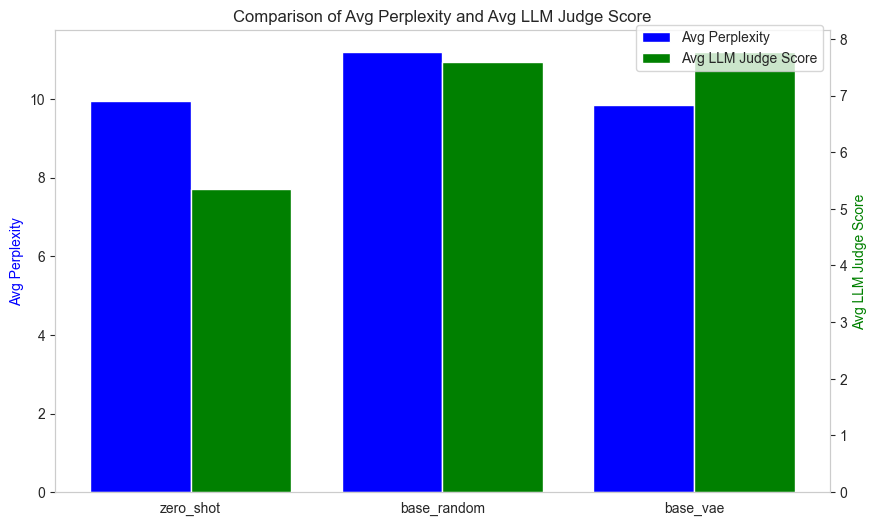

In [9]:
# Create plot comparing avg perplexity and avg llm_judge_score across zero_shot, base_random, base_vae
fig, ax1 = plt.subplots(figsize=(10, 6))
models_to_plot = ['zero_shot', 'base_random', 'base_vae']
x = np.arange(len(models_to_plot))
avg_perplexities = [summary_df[summary_df['model'] == model]['avg_perplexity'].values[0] for model in models_to_plot]
avg_llm_scores = [
    summary_df[summary_df['model'] == model]['avg_llm_judge_score'].values[0] for model in models_to_plot
]
ax1.bar(x - 0.2, avg_perplexities, width=0.4, label='Avg Perplexity', color='b')
ax2 = ax1.twinx()
ax2.bar(x + 0.2, avg_llm_scores, width=0.4, label='Avg LLM Judge Score', color='g')
ax1.set_xticks(x)
ax1.set_xticklabels(models_to_plot)
ax1.set_ylabel('Avg Perplexity', color='b')
ax2.set_ylabel('Avg LLM Judge Score', color='g')
ax1.grid(False)
ax2.grid(False)
plt.title('Comparison of Avg Perplexity and Avg LLM Judge Score')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.show()

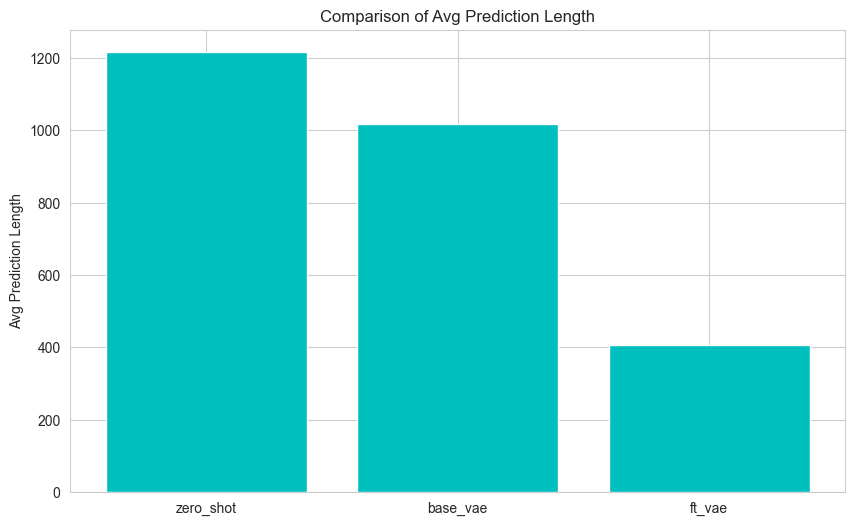

In [10]:
# Create plot comparing avg prediction length between zero-shot, base vae, and fine-tuned vae models
fig, ax = plt.subplots(figsize=(10, 6))
models_to_plot = ['zero_shot', 'base_vae', 'ft_vae']
x = np.arange(len(models_to_plot))
avg_pred_lengths = [summary_df[summary_df['model'] == model]['avg_prediction_length'].values[0] for model in models_to_plot]
ax.bar(x, avg_pred_lengths, color='c')
ax.set_xticks(x)
ax.set_xticklabels(models_to_plot)
ax.set_ylabel('Avg Prediction Length')
plt.title('Comparison of Avg Prediction Length')
plt.show()

In [3]:
# Compare prediction length between ft_vae, MusicCaps and LP-MusicCaps
from datasets import load_dataset


df_mc = load_dataset("google/MusicCaps", split="train").to_pandas()
df_mc['caption_length'] = df_mc['caption'].astype(str).apply(len)
avg_mc_caption_length = df_mc['caption_length'].mean()
print(f"Average MusicCaps caption length: {avg_mc_caption_length}")

df_lp_mc = load_dataset("seungheondoh/LP-MusicCaps-MC", split="train").to_pandas()
df_lp_mc['caption_length'] = df_lp_mc['caption_paraphrase'].astype(str).apply(len)
avg_lp_mc_caption_length = df_lp_mc['caption_length'].mean()
print(f"Average LP-MusicCaps caption length: {avg_lp_mc_caption_length}")

ft_vae_avg_length = summary_df[summary_df['model'] == 'ft_vae']['avg_prediction_length'].values[0]
print(f"Average ft_vae prediction length: {ft_vae_avg_length}")

Average MusicCaps caption length: 287.0637565658395
Average LP-MusicCaps caption length: 280.8336462636125


NameError: name 'summary_df' is not defined

In [12]:
# Create huggingface datasets for further analysis
for model in models:
    df = merged_predictions[model]
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
    hf_dataset_dict.push_to_hub(f"bsienkiewicz/{model}-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/525 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/526 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/526 [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/522 [00:00<?, ?B/s]